<a href="https://colab.research.google.com/github/jackhax/jack.github.io/blob/master/sdp_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

! pip install lime
! pip install grad-cam

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import cv2
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
from PIL import ImageFile
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import torch.nn as nn
import torch.nn.functional as f
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
) 
import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(0)
import sys

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
from PIL import Image
from os import listdir
from os.path import isfile, join
import random

inception_v3 = torch.load(r'/content/drive/MyDrive/aptos2019-blindness-detection/inception_v3.pth')
myPath = r'/content/drive/MyDrive/aptos2019-blindness-detection/train_images'
onlyfiles = [f for f in listdir(myPath) if isfile(join(myPath, f))]
testLabel = pd.read_csv('/content/drive/MyDrive/aptos2019-blindness-detection/train.csv')

In [4]:
# resize and take the center part of image to what our model expects
import cv2
def get_input_transform():
    IMAGE_SIZE = 28 
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([transforms.Resize([299,299]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)


In [5]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [6]:
import tensorflow as tf
from PIL import Image
import cv2
import base64

def predict(image):
  i = 0
  predictions = []
  for img in image:
    i+=1
    #img *= 255
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray((img.astype(np.uint8)))#*255).astype(np.uint8)).convert('RGB')

    # if i%10 == 0:
    #   plt.imshow(img)
    #   plt.show()

    img_t = get_input_tensors(img)
    inception_v3.cuda()
    pred = inception_v3(img_t.cuda())
    #pred = pred.argmax(dim=1).cpu().detach()
    predictions.append(pred.cpu().detach().numpy()[0])
  return np.array(predictions)

images = [
          cv2.imread(os.path.join(myPath,onlyfiles[77])),
          cv2.imread(os.path.join(myPath,onlyfiles[5]))
        ]
F = predict(images)


def get_probability(logits):
  prob = np.array(tf.nn.softmax(logits))
  probability = []
  for i in range(len(prob)):
    d = dict()
    for j in range(len(prob[i])):
      d[j] = float("{:.2f}".format(float(prob[i][j])*100))
    d= sorted(d.items(), key=lambda x: x[1], reverse=True)
    probability.append(d)
  
  return probability

def tabular_dict(d):
  d = dict(d)
  s = 'Class\tProbability'
  for k in d.keys():
    s += '\n' + str(k) +'\t'+ str(d[k])
  return s


# Take in base64 string and return cv image
def stringToRGB(base64_string):
    imgdata = base64.b64decode(str(base64_string))
    image = Image.open(io.BytesIO(imgdata))
    return cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)

get_probability(F)

[[(4, 100.0), (0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0)],
 [(0, 98.86), (1, 0.66), (3, 0.26), (4, 0.2), (2, 0.01)]]

In [ ]:
from tqdm import tqdm
import random

random.shuffle(onlyfiles)

i = 0
selected_images = dict()

k = [x for x in range(5)]

for imgPath in tqdm(onlyfiles):
  img = cv2.imread(os.path.join(myPath,imgPath))
  s = img.shape
  pred = predict([img]).argmax()
  if(((s[0]*s[1]) <= 1600000) and pred in k):
    selected_images[pred] = imgPath
    k.remove(pred)
    print('Found:',pred)
  if(k == []):
    break
     
print(selected_images)
  

  0%|          | 3/3662 [00:02<51:41,  1.18it/s]  

Found: 1


  0%|          | 4/3662 [00:03<52:06,  1.17it/s]

Found: 2


  0%|          | 5/3662 [00:04<1:02:29,  1.03s/it]

Found: 0


  1%|          | 35/3662 [00:40<1:06:51,  1.11s/it]

In [24]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from lime import lime_image
from skimage.segmentation import mark_boundaries

def explainations(imagePath):
  imagePath = os.path.join(myPath,imagePath)
  pred = predict([cv2.imread(imagePath)])
  img = Image.open(imagePath)
  sample = cv2.cvtColor(cv2.imread(imagePath),cv2.COLOR_BGR2RGB)
  img_t = get_input_tensors(img)

  target_layers = [inception_v3.Mixed_7c.branch_pool]
  cam = GradCAM(model=inception_v3, target_layers=target_layers, use_cuda=True)
  grayscale_cam = cam(input_tensor=img_t, target_category=None)
  grayscale_cam = grayscale_cam[0, :]
  cam_image = show_cam_on_image(cv2.resize(sample/255,(299,299)) ,grayscale_cam, use_rgb=True)

  explainer = lime_image.LimeImageExplainer()
  explanation2 = explainer.explain_instance(
        sample, 
        predict, 
        top_labels=5, 
        hide_color=1, 
        num_samples=1000
  )
  temp_1, mask_1 = explanation2.get_image_and_mask(explanation2.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
  temp_2, mask_2 = explanation2.get_image_and_mask(explanation2.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

  return {
            'sample':sample,
            'prediction': pred,
            'gradcam_image': cam_image,
            'lime_explaination': explanation2,
            'lime_masked_image':mark_boundaries(temp_2, mask_2)
        }


In [ ]:
xai = []
for i in range(5):
  res = explainations(selected_images[i])
  xai.append(res)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

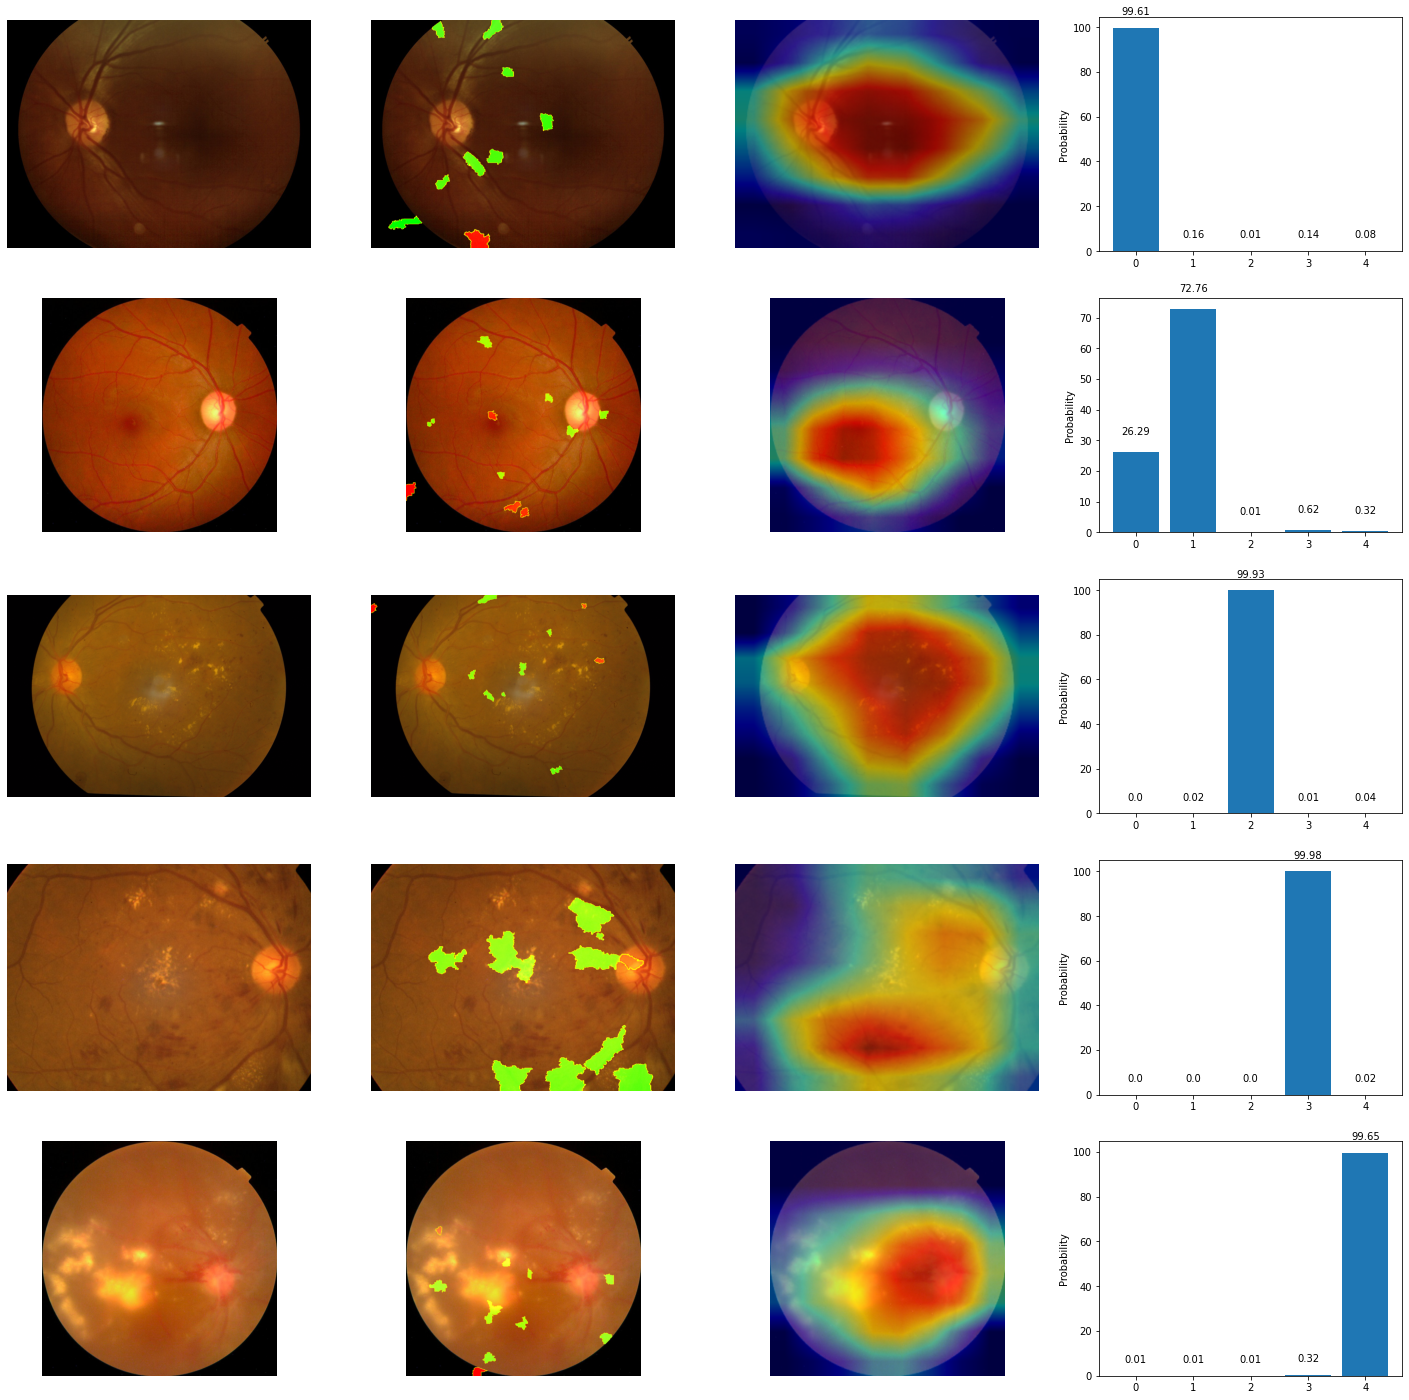

In [ ]:
f, axarr = plt.subplots(5,4,figsize=(25,25))

for x in range(len(xai)):
    pred = xai[x]['prediction']
    pred = dict(get_probability(pred)[0])
    i = list(pred.keys())
    j = list(pred.values())
    sample = xai[x]['sample']
    h,w,_ = sample.shape
    axarr[x,0].imshow(sample)
    axarr[x,1].imshow(xai[x]['lime_masked_image'])
    axarr[x,2].imshow(cv2.resize(xai[x]['gradcam_image'],(w,h)))
    axarr[x,3].bar(i,j)
    axarr[x,3].set_ylabel("Probability")

    axarr[x,0].axis('off')
    axarr[x,1].axis('off')
    axarr[x,2].axis('off')

    rects = axarr[x,3].patches
    labels = list(pred.values())
    for rect, label in zip(rects, labels):
      height = rect.get_height()
      axarr[x,3].text(
          rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
      )

plt.show()

predicted: 0 1 2 3 4 <br>
actual:    0 0 4 2 3

In [7]:
def get_actual(image):
  items = testLabel.loc[testLabel['id_code'] == image.split('.')[0]]
  return int(items['diagnosis'])

for x in range(5):
  print(get_actual(selected_images[x]))

NameError: ignored

In [8]:
from tqdm import tqdm
import random

random.shuffle(onlyfiles)

i = 0
selected_images1 = dict()

k = [x for x in range(5)]

for imgPath in tqdm(onlyfiles):
  img = cv2.imread(os.path.join(myPath,imgPath))
  s = img.shape
  pred = predict([img]).argmax()
  if(((s[0]*s[1]) <= 1600000) and (pred in k) and (pred == get_actual(imgPath))):
    selected_images1[pred] = imgPath
    k.remove(pred)
    print('Found:',pred)
  if(k == []):
    break
     
print(selected_images1)

  0%|          | 1/3662 [00:00<07:38,  7.99it/s]

Found: 2


  0%|          | 5/3662 [00:00<07:48,  7.80it/s]

Found: 0


  2%|▏         | 84/3662 [00:57<09:52,  6.04it/s]

Found: 4


  4%|▍         | 146/3662 [01:12<17:20,  3.38it/s]

Found: 1


 19%|█▉        | 710/3662 [03:41<15:21,  3.20it/s]

Found: 3
{2: '653534ded339.png', 0: 'd332d7b8a26e.png', 4: '262ad704319c.png', 1: '38e0e28d35d3.png', 3: 'ad2f0b9d059c.png'}


In [26]:
xai1 = []
for i in range(5):
  res = explainations(selected_images1[i])
  xai1.append(res)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

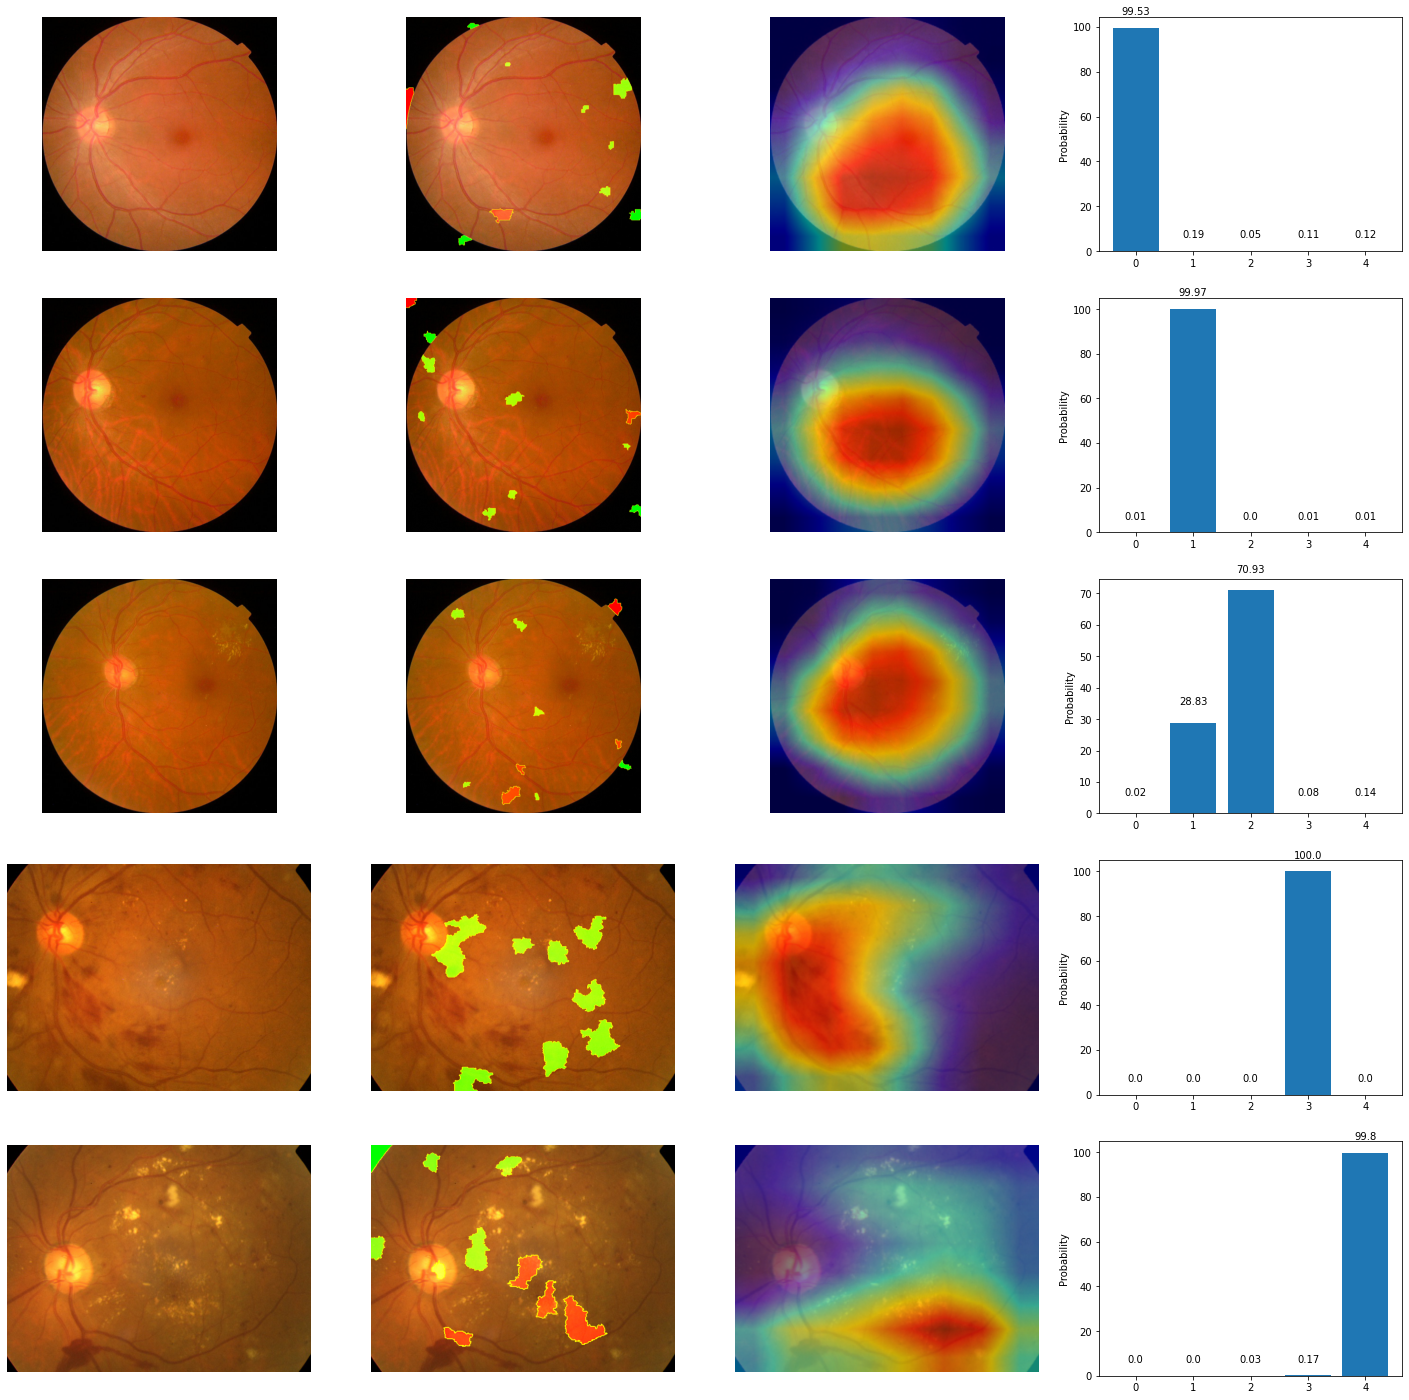

In [28]:
f, axarr1 = plt.subplots(5,4,figsize=(25,25))

for x in range(len(xai1)):
    pred = xai1[x]['prediction']
    pred = dict(get_probability(pred)[0])
    i = list(pred.keys())
    j = list(pred.values())
    sample = xai1[x]['sample']
    h,w,_ = sample.shape
    axarr1[x,0].imshow(sample)
    axarr1[x,1].imshow(xai1[x]['lime_masked_image'])
    axarr1[x,2].imshow(cv2.resize(xai1[x]['gradcam_image'],(w,h)))
    axarr1[x,3].bar(i,j)
    axarr1[x,3].set_ylabel("Probability")

    axarr1[x,0].axis('off')
    axarr1[x,1].axis('off')
    axarr1[x,2].axis('off')

    rects = axarr1[x,3].patches
    labels = list(pred.values())
    for rect, label in zip(rects, labels):
      height = rect.get_height()
      axarr1[x,3].text(
          rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
      )

plt.show()